# Import libraries

In [1]:
from transformers import pipeline 
import numpy as np
import torch
import pandas as pd 
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, BertForSequenceClassification,AutoTokenizer
from utils import *
bert_ckpt = "phnghiapro/distilbert-base-uncased-distilled-clinc"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pipe = pipeline('text-classification', model=bert_ckpt, device=device) 
print("device : ",device)
print("device of pipeline : ", pipe.model.device)

/home/nghiaph/workspace_nghia/Using_LLaMA_FAISS_and_LangChain_for_Question-Answering/utils.py:9: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_score = load_metric("accuracy")


device :  cuda:0
device of pipeline :  cuda:0


# plot the distribution of the weights

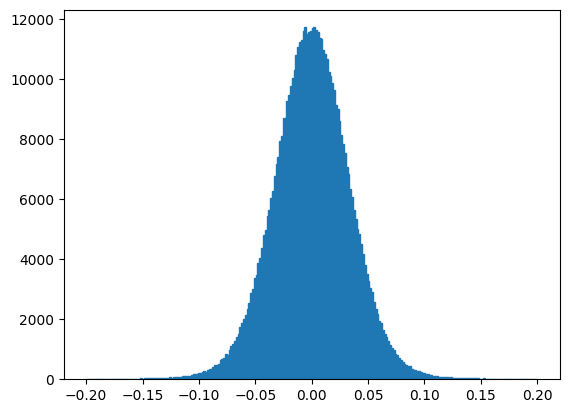

In [2]:
state_dict = pipe.model.to('cpu').state_dict()
weights = state_dict['distilbert.transformer.layer.0.attention.out_lin.weight']
plt.hist(weights.flatten().numpy(), bins=250, range=(-0.2,0.2), edgecolor="C0")
plt.show()

In [3]:
# value distributed in small range [-0.1, 0.1]
zero_point = 0 
scale = (weights.max() - weights.min()) / 255 

In [4]:
(weights / scale + zero_point).clamp(-128,127).round().char()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  9,   3,   2,  ...,  -4,   7,   0],
        [ -9,  -6,   6,  ...,   1,   5,  -3],
        ...,
        [  6,   0,  12,  ...,   0,   6,   0],
        [  1,  -3, -12,  ...,  12,  -7, -13],
        [-12,   0, -10,  ...,   8,   2,   0]], dtype=torch.int8)

# Compare time and size 


In [5]:
from torch import quantize_per_tensor 
dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale=scale, zero_point=zero_point, dtype=dtype) 
quantized_weights.int_repr() 


tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  9,   3,   2,  ...,  -4,   7,   0],
        [ -9,  -6,   6,  ...,   1,   5,  -3],
        ...,
        [  6,   0,  12,  ...,   0,   6,   0],
        [  1,  -3, -12,  ...,  12,  -7, -13],
        [-12,   0, -10,  ...,   8,   2,   0]], dtype=torch.int8)

## compare time

In [6]:
# %%timeit
# weights @ weights

In [7]:
from torch.nn.quantized import QFunctional 
q_fn = QFunctional() 


In [8]:
# %%timeit
# q_fn.mul(quantized_weights, quantized_weights)

In [9]:
# (1.26 milliseconds) / (95.9 microseconds) =
# 13.1386861
# 13 time faster

## compare size 


In [10]:
import sys
sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())
# decrease 4 times in size
#3.999755879241598


/tmp/ipykernel_2844652/2430007284.py:2: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())


3.999755879241598

# Quantize the model

In [23]:
from torch.quantization import quantize_dynamic 
model = (AutoModelForSequenceClassification.from_pretrained(bert_ckpt))
model_quantized = quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8)
# model_quantized.to(device)

## Plot all the model benchmard

In [115]:
# save perf_metrics
import json
# with open("perf_metrics.json", "w") as f:
#     json.dump(perf_metrics, f)
# load perf_metrics
with open("perf_metrics.json", "r") as f:
    perf_metrics = json.load(f)

In [29]:
# from utils import *

# #BERT baseline
# optim_type = "BERT baseline"
# print(optim_type)
model_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
# pipe = pipeline("text-classification",model=model_ckpt,tokenizer=tokenizer,device='cpu')
# pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
# perf_metrics = pb.run_benchmark()
# # perf_metrics.update(pb.run_benchmark())

BERT baseline
Model size (MB) - 418.15
Average latency ms - 0.010 +/- 0.280
Accuracy on test set - 0.867


In [30]:
# #Distillation
# optim_type = "Distillation"
# print(optim_type)
# distilled_ckpt = "phnghiapro/distilbert-base-uncased-distilled-clinc"
# distilled_pipe = pipeline('text-classification', model=distilled_ckpt,device='cpu')
# pb = PerformanceBenchmark(distilled_pipe, clinc["test"], optim_type=optim_type)
# distilbert_benchmark = PerformanceBenchmark(distilled_pipe, clinc["test"], optim_type)
# # perf_metrics = pb.run_benchmark()
# perf_metrics.update(distilbert_benchmark.run_benchmark())

Distillation
Model size (MB) - 255.88
Average latency ms - 0.005 +/- 0.074
Accuracy on test set - 0.877


In [34]:
# #Distillation + quantization
# optim_type = "Distillation + quantization"
# print(optim_type)
# model_ckpt = "phnghiapro/distilbert-base-uncased-distilled-clinc"
# tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# pipe = pipeline("text-classification",
#                 model=model_quantized,
#                 tokenizer=tokenizer,
#                 device='cpu'
#                 )
# pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
# # perf_metrics = pb.run_benchmark()
# perf_metrics.update(pb.run_benchmark())

Distillation + quantization
Model size (MB) - 132.39
Average latency ms - 0.004 +/- 0.150
Accuracy on test set - 0.878


In [40]:
perf_metrics

{'BERT baseline': {'size_mb': 418.14669132232666,
  'time_avg_ms': 10.054126690374687,
  'time_std_ms': 0.2803475094624616,
  'accuracy': 0.8672727272727273},
 'Distillation': {'size_mb': 255.88143634796143,
  'time_avg_ms': 5.309071037918329,
  'time_std_ms': 0.07436598707911952,
  'accuracy': 0.8765454545454545},
 'Distillation + quantization': {'size_mb': 132.3907289505005,
  'time_avg_ms': 3.588528042891994,
  'time_std_ms': 0.1503000480642237,
  'accuracy': 0.8778181818181818}}

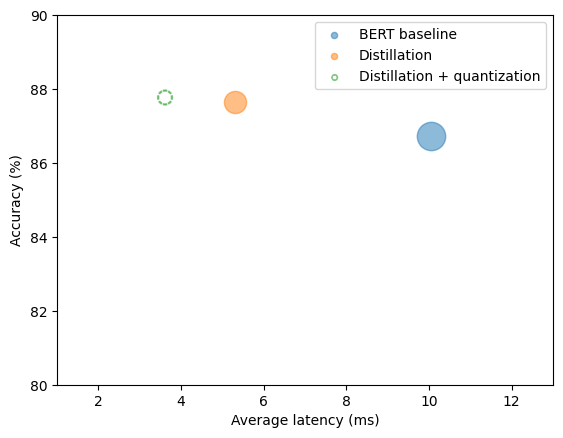

In [41]:
plot_metrics(perf_metrics, optim_type)

# Experiment ONNX

In [148]:
import os 
from psutil import cpu_count 
os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = 'ACTIVE'


In [150]:
from transformers.convert_graph_to_onnx import convert
model_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
onnx_model_path = Path("onnx/model.onnx")
convert(framework="pt", model=model_ckpt, tokenizer=tokenizer,
    output=onnx_model_path, opset=12, pipeline_name="text-classification")

/home/nghiaph/GEC/GEC_env/lib/python3.8/site-packages/transformers/convert_graph_to_onnx.py:379: FutureWarning: The `transformers.convert_graph_to_onnx` package is deprecated and will be removed in version 5 of Transformers
  warnings.warn(


ONNX opset version set to: 12
Loading pipeline (model: transformersbook/distilbert-base-uncased-distilled-clinc, tokenizer: DistilBertTokenizerFast(name_or_path='phnghiapro/distilbert-base-uncased-distilled-clinc', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True))


Exception: Folder onnx is not empty, aborting conversion

In [152]:
from onnxruntime import (GraphOptimizationLevel, InferenceSession,
 SessionOptions)
def create_model_for_provider(model_path, provider="CPUExecutionProvider"):
    options = SessionOptions()
    # options.intra_op_num_threads = 1
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
    session = InferenceSession(str(model_path), options, providers=[provider])
    session.disable_fallback()
    return session
onnx_model = create_model_for_provider(onnx_model_path)

In [153]:
from datasets import load_metric,load_dataset

clinc = load_dataset("clinc_oos", "plus")
def tokenizer_text(batch):
    return tokenizer(batch["text"],truncation=True)
clinc_enc = clinc.map(tokenizer_text, batched=True)
clinc_enc = clinc_enc.rename_column("intent", "labels")

Map:   0%|          | 0/3100 [00:00<?, ? examples/s]

In [154]:
inputs = clinc_enc["test"][:1]
del inputs["labels"]
del inputs["text"]

In [155]:
print(inputs)

{'input_ids': [[101, 2129, 2052, 2017, 2360, 4875, 1999, 3059, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [156]:
logits_onnx = onnx_model.run(None, inputs)[0]
print(logits_onnx.shape)

(1, 151)


In [157]:
np.argmax(logits_onnx)


61

In [158]:
clinc_enc["test"][0]["labels"]


61

# create Onnx Pipeline 


In [159]:
# create ONNX pipeline 
from scipy.special import softmax 
class OnnxPipeline:
    def __init__(self, onnx_model,tokenizer):
        self.onnx_model = onnx_model
        self.tokenizer = tokenizer
    def __call__(self, query): 
        inputs = self.tokenizer(query, return_tensors="pt") # input_ids attention_mask shape (1, seq_len) vs (1, seq_len)
        inputs_onnx = {k: v.cpu().detach().numpy() for k, v in inputs.items()}
        logits = self.onnx_model.run(None, inputs_onnx)[0][0,:] # shape (n_classes,)
        probs = softmax(logits) # shape (n_classes,)
        pred_idx = np.argmax(probs).item() # shape ()
        return [{
                "label": intents.int2str(pred_idx),
                "score": probs[pred_idx]
                }]
# test the pipeline
onnx_pipe = OnnxPipeline(onnx_model,tokenizer)
query = """onnx_pipe("hey, I want to buy a macbook pro")"""
onnx_pipe(query)


[{'label': 'order', 'score': 0.19629458}]

In [165]:
class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *arg,model_path, **kwargs):
        super().__init__(*arg, **kwargs)
        self.model_path = model_path
    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024*1024)
        print(f"Model size MB: {size_mb:.2f} MB")
        return {"size_mb": size_mb}

# plot benchmark Onnx

In [166]:
type(perf_metrics)
print(perf_metrics)

{'BERT baseline': {'size_mb': 418.14669132232666, 'time_avg_ms': 10.054126690374687, 'time_std_ms': 0.2803475094624616, 'accuracy': 0.8672727272727273}, 'Distillation': {'size_mb': 255.88143634796143, 'time_avg_ms': 5.309071037918329, 'time_std_ms': 0.07436598707911952, 'accuracy': 0.8765454545454545}, 'Distillation + quantization': {'size_mb': 132.3907289505005, 'time_avg_ms': 3.588528042891994, 'time_std_ms': 0.1503000480642237, 'accuracy': 0.8778181818181818, 'size_mv': 255.97955417633057}, 'Distillation + ONNX': {'size_mb': 255.98, 'time_avg_ms': 0.013, 'accuracy': 0.868, 'time_std_ms': 0.33}}


In [167]:
perf_metrics

{'BERT baseline': {'size_mb': 418.14669132232666,
  'time_avg_ms': 10.054126690374687,
  'time_std_ms': 0.2803475094624616,
  'accuracy': 0.8672727272727273},
 'Distillation': {'size_mb': 255.88143634796143,
  'time_avg_ms': 5.309071037918329,
  'time_std_ms': 0.07436598707911952,
  'accuracy': 0.8765454545454545},
 'Distillation + quantization': {'size_mb': 132.3907289505005,
  'time_avg_ms': 3.588528042891994,
  'time_std_ms': 0.1503000480642237,
  'accuracy': 0.8778181818181818,
  'size_mv': 255.97955417633057},
 'Distillation + ONNX': {'size_mb': 255.98,
  'time_avg_ms': 0.013,
  'accuracy': 0.868,
  'time_std_ms': 0.33}}

In [168]:
# change key model_size_mb to size_mv 
# Distillation + ONNX
# Model size MB: 255.98 MB
# Average latency ms - 0.013 +/- 0.330
# Accuracy on test set - 0.868
# dict = {
#     "size_mb" : 255.98,
#     "time_avg_ms" : 0.013,
#     "accuracy" : 0.868, 
#     "time_std_ms" : 0.330
# }
# perf_metrics["Distillation + ONNX"] = dict

In [169]:
optim_type = "Distillation + ONNX"
print(optim_type)
pb = OnnxPerformanceBenchmark(onnx_pipe, clinc["test"], optim_type=optim_type,model_path=onnx_model_path)
perf_metrics.update(pb.run_benchmark())

Distillation + ONNX
Model size MB: 255.98 MB
Average latency ms - 0.004 +/- 0.083
Accuracy on test set - 0.868


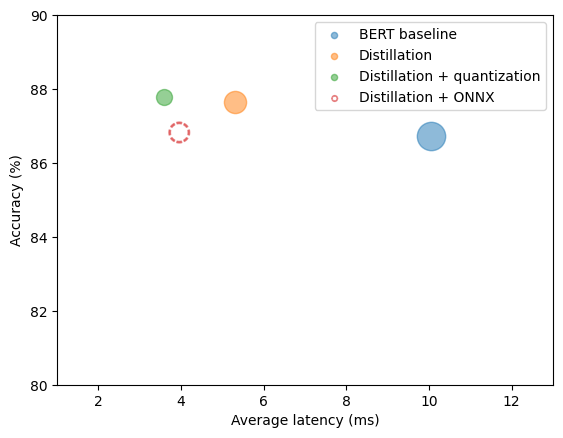

In [170]:
plot_metrics(perf_metrics, optim_type)


# Use ORT to quantization the model


In [174]:
from onnxruntime.quantization import quantize_dynamic, QuantType
model_input = "onnx/model.onnx"
model_output = "onnx/model_quantized.onnx"
quantize_dynamic(model_input, model_output, weight_type=QuantType.QInt8)

Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.0/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.0/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.1/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.1/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.2/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.2/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.3/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.3/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.4/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.4/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.5/attention/MatMul]
Ignore MatM

In [175]:
onnx_quantized_model = create_model_for_provider(model_output)
onnx_quantized_pipe = OnnxPipeline(onnx_quantized_model,tokenizer)
optim_type = "Distillation + ONNX + quantization"
print(optim_type)
pb = OnnxPerformanceBenchmark(onnx_quantized_pipe, clinc["test"], optim_type=optim_type,model_path=model_output)
perf_metrics.update(pb.run_benchmark())

Distillation + ONNX + quantization
Model size MB: 64.33 MB
Average latency ms - 0.002 +/- 0.024
Accuracy on test set - 0.876


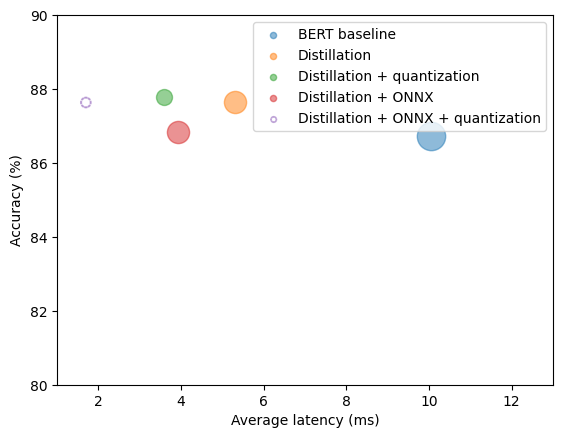

In [176]:
plot_metrics(perf_metrics, optim_type)
